# Xử lý dữ liệu
- Thứ tự thực hiện xử lý dữ liệu:
    - Nhập dữ liệu từ file
    - Convert column
    - Điền các giá trị NA, dựa vào kết quả phân tích
    - Tạo biến giả (dummy variable)
    - Scaling 1 vài dữ liệu và chuyển kiểu dữ liệu về float32
    - Tách tập train, test
    - Đưa vào auto-sklearn và AutoKeras để train, validation, sau đó test bằng test set.

- Những việc cần làm: (trống)

In [1]:
import warnings
import os
from pprint import pprint
import numpy as np
import pandas as pd
import datetime 
import seaborn as sns
import matplotlib.pyplot as plt
import random

import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import tensorflow as tf

import autokeras as ak
import autosklearn.regression

import pickle

random.seed(1000)
# OK

Matplotlib is building the font cache; this may take a moment.


In [2]:
# Ignoring future warnings and deprecation warnings so as not to make the notebook full of warnings
warnings.filterwarnings("ignore")
# OK

In [3]:
# Reading the first few lines of the dataset
data = pd.read_csv("VN_housing_dataset.csv")
data.head()
# OK

,Unnamed: 0,Unnamed: 0.1,Ngày,Địa chỉ,Quận,Huyện,Loại hình nhà ở,Giấy tờ pháp lý,Số tầng,Số phòng ngủ,Diện tích,Dài,Rộng,Giá/m2
0,0,0.0,2020-08-05,"Đường Hoàng Quốc Việt, Phường Nghĩa Đô, Quận C...",Quận Cầu Giấy,Phường Nghĩa Đô,"Nhà ngõ, hẻm",Đã có sổ,4,5 phòng,46 m2,NaN,NaN,"86,96 triệu/m2"
1,1,1.0,2020-08-05,"Đường Kim Giang, Phường Kim Giang, Quận Thanh ...",Quận Thanh Xuân,Phường Kim Giang,"Nhà mặt phố, mặt tiền",NaN,NaN,3 phòng,37 m2,NaN,NaN,"116,22 triệu/m2"
2,2,2.0,2020-08-05,"phố minh khai, Phường Minh Khai, Quận Hai Bà T...",Quận Hai Bà Trưng,Phường Minh Khai,"Nhà ngõ, hẻm",Đã có sổ,4,4 phòng,40 m2,10 m,4 m,65 triệu/m2
3,3,3.0,2020-08-05,"Đường Võng Thị, Phường Thụy Khuê, Quận Tây Hồ,...",Quận Tây Hồ,Phường Thụy Khuê,"Nhà ngõ, hẻm",Đã có sổ,NaN,6 phòng,51 m2,12.75 m,4 m,100 triệu/m2
4,4,4.0,2020-08-05,"Đường Kim Giang, Phường Kim Giang, Quận Thanh ...",Quận Thanh Xuân,Phường Kim Giang,"Nhà ngõ, hẻm",NaN,NaN,4 phòng,36 m2,9 m,4 m,"86,11 triệu/m2"


In [4]:
# The length of the dataset before cleaning and removing outliers
print("The initial length of the dataset is", str(len(data)), "rows.")
data.isna().sum()
# OK

The initial length of the dataset is 82484 rows.


In [5]:
# Đặt tên lại các cột
df_renamed = data.rename(columns = {"Ngày":"date", "Địa chỉ":"address", "Quận":"district", 
                                  "Huyện":"ward", "Loại hình nhà ở":"type_of_housing",
                                 "Giấy tờ pháp lý":"legal_paper", "Số tầng":"num_floors",
                                 "Số phòng ngủ":"num_bed_rooms", "Diện tích":"squared_meter_area",
                                 "Dài":"length_meter", "Rộng":"width_meter", "Giá/m2":"price"})

df_renamed = df_renamed.where(pd.notnull(df_renamed), "NaN")

# Remove houses with "10 plus" floors and bed rooms, since this cannot be exactly quantified
df_renamed = df_renamed[df_renamed['num_floors'] != 'Nhiều hơn 10']
df_renamed = df_renamed[df_renamed['num_bed_rooms'] != 'nhiều hơn 10 phòng']

# Clean columns and convert numerical columns to float type
df_renamed['num_floors'] = df_renamed['num_floors'].str.strip().astype(float)
df_renamed['num_bed_rooms'] = df_renamed['num_bed_rooms'].str.replace(' phòng','').str.strip().astype(float)
df_renamed['squared_meter_area'] = df_renamed['squared_meter_area'].str.replace(' m2','').str.strip().astype(float)
df_renamed['length_meter'] = df_renamed['length_meter'].str.replace(' m','').str.strip().astype(float)
df_renamed['width_meter'] = df_renamed['width_meter'].str.replace(' m','').str.strip().astype(float)

# Clean and convert all prices to million/m2 instead of VND/m2 or billion/m2
df_renamed.loc[df_renamed['price'].str.contains(' tỷ/m2', na=False), 'price'] = df_renamed.loc[df_renamed['price'].str.contains(' tỷ/m2', na=False), 'price'].str.replace(' tỷ/m2','').str.replace('.','').str.replace(',','.').astype(float) * 1000
df_renamed.loc[df_renamed['price'].str.contains(' triệu/m2', na=False), 'price'] = df_renamed.loc[df_renamed['price'].str.contains(' triệu/m2', na=False), 'price'].str.replace(' triệu/m2','').str.replace('.','').str.replace(',','.').astype(float)
df_renamed.loc[df_renamed['price'].str.contains(' đ/m2', na=False), 'price'] = df_renamed.loc[df_renamed['price'].str.contains(' đ/m2', na=False), 'price'].str.replace(' đ/m2','').str.replace('.','').str.replace(',','.').astype(float) * 0.000001

df_renamed.head()
df_renamed.to_csv("full_data.csv", index = False)

In [6]:
def filling_na(df):
  for index, row in df.iterrows():
    if pd.isna(row["num_floors"]):
      df.at[index, "num_floors"] = random.choice([4, 5])

    if pd.isna(row["squared_meter_area"]):
      continue
    elif not pd.isna(row["length_meter"]) and pd.isna(row["width_meter"]):
      df.at[index, "width_meter"] = row["squared_meter_area"] / row["length_meter"]
    elif pd.isna(row["length_meter"]) and not pd.isna(row["width_meter"]):
      df.at[index, "length_meter"] = row["squared_meter_area"] / row["width_meter"]
    else:
      continue

  df = df.drop("Unnamed: 0", axis = 1)
  df = df.drop("Unnamed: 0.1", axis = 1)
  df = df.drop(["date", "address"], axis = 1)
  # Xóa bỏ một số giá trị bất thường
  df.drop(df[df['price'] > 400].index, inplace = True)  
  df.drop(df[df['price'] < 1].index, inplace = True)
  df.drop(df[df['num_floors'] > 10].index, inplace = True)
  df.drop(df[abs(df['squared_meter_area'] - df["length_meter"]*df["width_meter"]) > 50].index, inplace = True)
  df.drop(df[df["legal_paper"] == "NaN"].index, inplace=True)
  # Loại bỏ một số cột.
  df = df[["district", "ward", "type_of_housing", "legal_paper", "num_floors", "num_bed_rooms", "squared_meter_area", "price"]]


  print(df.isna().sum())
  df = df.dropna()
  df = df.reset_index()
  return df
    
df_renamed = filling_na(df_renamed)
X_train, X_test, y_train, y_test = train_test_split(df_renamed.drop(['price'], axis=1), df_renamed["price"], test_size=0.2, random_state=2032)
X_train.assign(price=y_train).to_csv("train_data.csv", index=False)
X_test.assign(price=y_test).to_csv("test_data.csv", index=False)

# The length of the dataset after dropping null values

print("The length of the dataset after dropping null values is", str(len(df_renamed)), "rows.")
df_renamed.head()

district               0
ward                   0
type_of_housing        0
legal_paper            0
num_floors             0
num_bed_rooms         31
squared_meter_area     0
price                  0
dtype: int64
The length of the dataset after dropping null values is 51179 rows.


,index,district,ward,type_of_housing,legal_paper,num_floors,num_bed_rooms,squared_meter_area,price
0,0,Quận Cầu Giấy,Phường Nghĩa Đô,"Nhà ngõ, hẻm",Đã có sổ,4.0,5.0,46.0,86.96
1,2,Quận Hai Bà Trưng,Phường Minh Khai,"Nhà ngõ, hẻm",Đã có sổ,4.0,4.0,40.0,65.0
2,3,Quận Tây Hồ,Phường Thụy Khuê,"Nhà ngõ, hẻm",Đã có sổ,4.0,6.0,51.0,100.0
3,7,Quận Hai Bà Trưng,Phường Đống Mác,"Nhà mặt phố, mặt tiền",Đã có sổ,6.0,5.0,32.0,184.38
4,9,Quận Hà Đông,Phường Văn Quán,"Nhà ngõ, hẻm",Đã có sổ,4.0,3.0,41.0,64.63


In [7]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X_train)
# Create dummies for categorical columns
preprocessor = ColumnTransformer([
    ("ohe", ohe, ["district", "ward", "type_of_housing", "legal_paper"]),
])
preprocessor.fit(X_train)

pipe = Pipeline([
    ("preprocess", preprocessor)
])

X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

X_train = X_train.astype("float32")
y_train = y_train.astype("float32")
X_test = X_test.astype("float32")
y_test = y_test.astype("float32")

# Sanity check to see if all train and test arrays have correct dimensions
if X_train.shape[0] == y_train.shape[0] and X_test.shape[0] == y_test.shape[0]:
    print("All train and test sets have correct dimensions.")

All train and test sets have correct dimensions.


# Tìm mô hình phù hợp bằng auto-sklearn

In [8]:
'''
automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=7200,
    per_run_time_limit=900,
    tmp_folder='autosklearn_tmp'
)

automl.fit(X_train, y_train)
pprint(automl.show_models(), indent=4)

# Lưu lại mô hình tốt nhất
x = automl.show_models()
#results = {"ensemble": x}
results = automl # the classifier/regressor itself
pickle.dump(results, open('auto_sklearn.pickle','wb'))

train_predictions = automl.predict(X_train)
print("Train RMSE score:", sklearn.metrics.mean_squared_error(y_train, train_predictions, squared=False))
test_predictions = automl.predict(X_test)
print("Test RMSE score:", sklearn.metrics.mean_squared_error(y_test, test_predictions, squared=False))
print(pd.Series(y_test - test_predictions).describe())
sns.histplot(y_test - test_predictions)
'''

'\nautoml = autosklearn.regression.AutoSklearnRegressor(\n    time_left_for_this_task=7200,\n    per_run_time_limit=900,\n    tmp_folder=\'autosklearn_tmp\'\n)\n\nautoml.fit(X_train, y_train)\npprint(automl.show_models(), indent=4)\n\n# Lưu lại mô hình tốt nhất\nx = automl.show_models()\n#results = {"ensemble": x}\nresults = automl # the classifier/regressor itself\npickle.dump(results, open(\'auto_sklearn.pickle\',\'wb\'))\n\ntrain_predictions = automl.predict(X_train)\nprint("Train RMSE score:", sklearn.metrics.mean_squared_error(y_train, train_predictions, squared=False))\ntest_predictions = automl.predict(X_test)\nprint("Test RMSE score:", sklearn.metrics.mean_squared_error(y_test, test_predictions, squared=False))\nprint(pd.Series(y_test - test_predictions).describe())\nsns.histplot(y_test - test_predictions)\n'

[118.70626462  82.82829402  77.78881549 ... 106.10464541  85.1825939
  91.3773733 ]
[118.70626462  82.82829402  77.78881549 ... 106.10464541  85.1825939
  91.3773733 ]
Accuracy for the final model is: 0.37624955284929434
Train RMSE score: 36.9743662467299
Test RMSE score: 36.86801892269624
Max error: 274.3663423289595


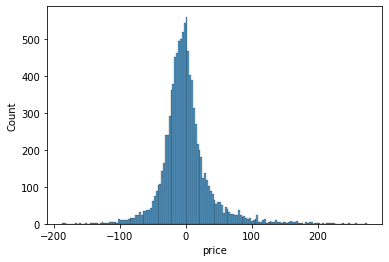

In [9]:
# Build model tốt nhất bằng sklearn
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

model = RandomForestRegressor(max_features=0.7517792740390704, min_samples_leaf=6,
                      n_estimators=512, n_jobs=1, random_state=1,
                      warm_start=True)
model.fit(X_train, y_train)


with open('final-model-6.pickle','wb') as f:
    pickle.dump(model,f)

# load
with open('final-model-6.pickle', 'rb') as f:
    model_2 = pickle.load(f)

print(model_2.predict(X_test))


test_predictions = model_2.predict(X_test)
print(test_predictions)
print("Accuracy for the final model is:", str(sklearn.metrics.mean_absolute_percentage_error(y_test, test_predictions)))
train_predictions = model_2.predict(X_train)
print("Train RMSE score:", sklearn.metrics.mean_squared_error(y_train, train_predictions, squared=False))
print("Test RMSE score:", sklearn.metrics.mean_squared_error(y_test, test_predictions, squared=False))
print("Max error:", sklearn.metrics.max_error(y_test, test_predictions))
sns.histplot(y_test - test_predictions)

Kết quả train model
- Model train lần 1: (đầy đủ 6 model của auto-sklearn)
    - Train RMSE score: 35907.58159648503
    - Test RMSE score: 59333.95487043406
    - Accuracy score: 38.4495479475675

- Model train lần 2: (Chỉ có 1 model tốt nhất)
    - Accuracy score: 45.90740139154685

- Model train lần 3: (Thay đổi điều kiện loại bỏ giá trị bất thường)
    - Accuracy for the auto-sklearn model is: 64.02317728894509
    - Train RMSE score: 30825.360551413673
    - Test RMSE score: 23015.72515244434

- Model train lần 4: (Thay đổi điều kiện loại bỏ giá trị bất thường)
    - Accuracy for the auto-sklearn model is: 58.67163442853855
    - Train RMSE score: 4834.075482152234
    - Test RMSE score: 5070.393852307886

- Model train lần thứ 5: (final-model-2) - thay đổi các điều kiện loại bỏ giá trị bất thường.
    - Accuracy for the auto-sklearn model is: 52.97973446439696
    - Train RMSE score: 4253.366269887903
    - Test RMSE score: 4681.643697988176

- Model train lần thứ 6: Chỉ giữ lại 4 cột đầu - LinearSVR.
    - Accuracy for the auto-sklearn model is: 59.833783012518715
    - Train RMSE score: 4187.313999173774
    - Test RMSE score: 4217.688233321773
- Model train lần thứ 7: Chỉ giữ lại 4 cột đầu + Loại bỏ giấy tờ nan - RandomForestRegression:
    - Accuracy for the auto-sklearn model is: 63.65526714087563
    - Train RMSE score: 62.744871055503886
    - Test RMSE score: 69.61038789335248
- Model train lần thứ 8: Chỉ giữ lại 4 cột đầu + Loại bỏ giấy tờ nan - RandomForestRegression:
    - Accuracy for the auto-sklearn model is: 63.43588311130838
    - Train RMSE score: 63.19085095454653
    - Test RMSE score: 69.48621834561445
- Model train lần thứ 9: Điều chỉnh giá đất tối đa: 1 tỷ/m2 (thay vì 3 tỷ/m2)
    - Accuracy for the auto-sklearn model is: 59.69062492887485
    - Train RMSE score: 50.977970779966164
    - Test RMSE score: 49.37985717345978
- Model train lần thứ 10: Giữ lại tất cả các cột: (Kết quả không tốt hơn)

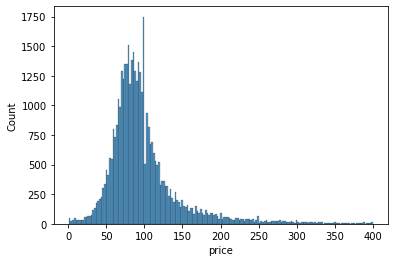

In [10]:
sns.histplot(y_train)
# sns.histplot(np.log(y_train))
# sns.histplot(y_train - train_predictions)
# sns.histplot(y_test - test_predictions)
# pd.Series(y_train - train_predictions).describe()
# pd.Series(y_test - test_predictions).describe()